<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/main/2024-09-23-titanium-foil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/main/2024-09-23-titanium-foil.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 2024-09-23 Titanium foil (etched)

A 310mg etched titanium foil is gas loaded with deuterium, in a 0.19L chamber.

In [1]:
# RUN THIS IF YOU ARE USING GOOGLE COLAB
import sys
import os
!git clone https://github.com/project-ida/arpa-e-experiments.git
sys.path.insert(0,'/content/arpa-e-experiments')
os.chdir('/content/arpa-e-experiments')

Cloning into 'arpa-e-experiments'...
remote: Enumerating objects: 1070, done.
remote: Counting objects: 100% (418/418), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 1070 (delta 338), reused 229 (delta 211), pack-reused 652 (from 1)
Receiving objects: 100% (1070/1070), 41.80 MiB | 10.50 MiB/s, done.
Resolving deltas: 100% (713/713), done.
Updating files: 100% (67/67), done.


In [2]:
# Libraries and helper functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.display import Video
from IPython.display import HTML

# Use our custom helper functions
# - process_data
# - plot_panels
# - plot_panels_with_scatter
# - print_info
# - load_data
from libs.helpers import *

# Necessary for using load_data on password protected data urls
# - authenticate
# - get_credentials
from libs.auth import *

In [3]:
meta = {
    "descriptor" : "Etched titanium foil" # This will go into the title of all plots
}

## Reading the raw data

### Temperature

In [4]:
# Read the tempearture data
temperature_df = load_data('http://nucleonics.mit.edu/data/csv-files/loading%20deloading%20runs/thermocouples_september_ti/thermocouples_september_ti-1-fullres.csv')

Data file loaded successfully!


In [5]:
# Print out basic description of the data, including any NaNs
print_info(temperature_df)

Measurements start at: 2024-09-23 19:37:42.710931
Measurements end at: 2024-09-28 09:59:59.316199
---------
Total number of measurements: 335764
Average time between measurements: 1.183380 s
---------
Most common Δt between measurements: 1.089 s (26087 instances)
Second most common Δt: 1.088 s (22934 instances)
Measurements with a Δt not equal to the most common: 309676 (92.23%)
---------
Total number of NaNs
Thermocouple1Ch1         0
Thermocouple1Ch2         0
Thermocouple1Ch3         0
Thermocouple1Ch4    335764
dtype: int64


`Thermocouple1Ch4` was offline for the whole experiment so we'll drop it.

`Thermocouple1Ch3` is the room temperature measurement and had a small number of issues. We'll fix this during the processing stage.

In [6]:
temperature_df.drop('Thermocouple1Ch4', axis=1, inplace=True) # Drop Thermocouple1Ch4

Since we'll only be interested in `Thermocouple1Ch1`, we'll rename it to make plotting a bit easier later.

In [7]:
temperature_df.rename(columns={'Thermocouple1Ch1': 'Temperature (C)'}, inplace=True)

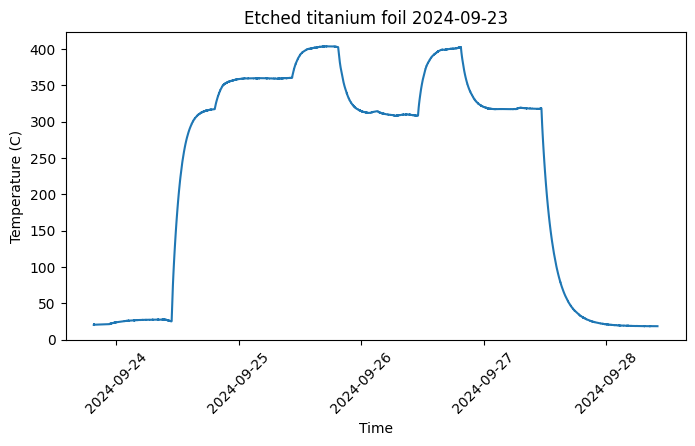

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(temperature_df['Temperature (C)'])
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.xticks(rotation=45)
plt.title(f"{meta['descriptor']} {temperature_df.index[0].date()}")
plt.show()

### Pressure

In [9]:
# Read the pressure data
pressure_df = pd.read_csv(
    'data/20240923_192738_Ti_etched_run_2_cycles+RTeq.csv',
    names=['time', 'Voltage1', 'Voltage2', 'Voltage3', 'Voltage4'],
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time',
    header=None
)

In [10]:
# Print out basic description of the data, including any NaNs
print_info(pressure_df)

Measurements start at: 2024-09-23 19:27:40
Measurements end at: 2024-09-28 10:02:30
---------
Total number of measurements: 395669
Average time between measurements: 1.006118 s
---------
Most common Δt between measurements: 1.0 s (393246 instances)
Second most common Δt: 2.0 s (2422 instances)
Measurements with a Δt not equal to the most common: 2422 (0.61%)
---------
Total number of NaNs
Voltage1    0
Voltage2    0
Voltage3    0
Voltage4    0
dtype: int64


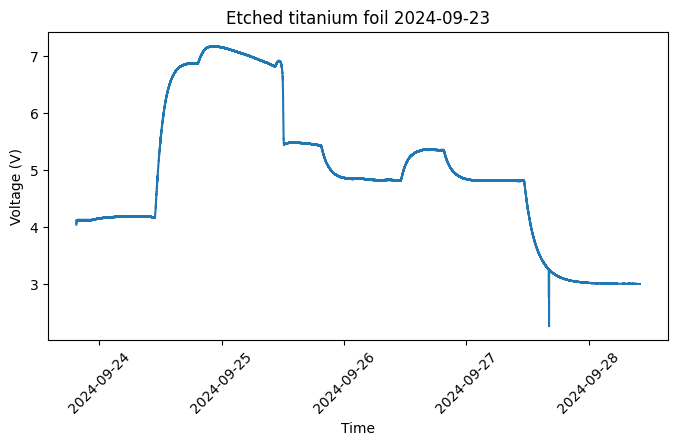

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(pressure_df['Voltage1'])
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.xticks(rotation=45)
plt.title(f"{meta['descriptor']} {pressure_df.index[0].date()}")
plt.show()

## Processing the data

### Corrupt data

There is a large spike in the pressure data about half way through 2024-09-27. We can identify the precise time be seeing where the voltage changes by more than 0.5V over a single measurement.

In [12]:
pressure_df[pressure_df['Voltage1'].diff().abs() > 0.5]

,Voltage1,Voltage2,Voltage3,Voltage4
time,,,,
2024-09-27 16:11:54,2.266237,0.003598,0.002366,0.002059
2024-09-27 16:11:55,3.249351,0.003290,0.002674,0.002366


Let's zoom in to this region

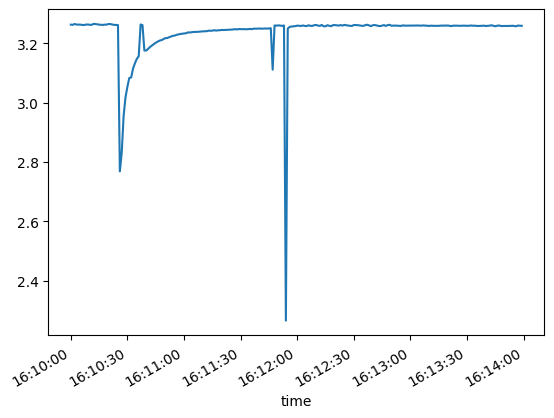

In [13]:
pressure_df['Voltage1']['2024-09-27 16:10':'2024-09-27 16:13'].plot();

It's likely that the largest spike is a result of data logging issues and so it seems sensible to remove the data points.

In [14]:
# Drop corrupt pressure readings
pressure_df.drop(pressure_df[pressure_df['Voltage1'].diff().abs() > 0.5].index, inplace=True)

### Combining data

To derive physical quantities from several diagnostics, we need to have simultaneous measurements. We'll therefore need to do some interpolation of the data. This is going to involve:
1. Mapping all measurements to the nearest second
2. Selecting overlapping time intervals from the data
3. Combining the data from all diagnostics into one dataframe
4. Interpolate to fill the NaNs that result from combining the data in step 3
5. Drop any NaNs that can sometimes be generated at the edges of the time range

In [15]:
combined_df = process_data([temperature_df, pressure_df], meta)

In [16]:
combined_df.head()

,Temperature (C),Thermocouple1Ch2,Thermocouple1Ch3,Voltage1,Voltage2,Voltage3,Voltage4
time,,,,,,,
2024-09-23 19:37:42,20.339845,20.251275,20.152189,4.125043,0.003905,0.003290,0.003290
2024-09-23 19:37:43,20.348467,20.243669,20.206811,4.126274,0.004521,0.003290,0.002366
2024-09-23 19:37:44,20.337898,20.242228,20.179550,4.125658,0.004213,0.003290,0.003290
2024-09-23 19:37:45,20.320853,20.239712,20.193624,4.124427,0.004829,0.002982,0.002366
2024-09-23 19:37:46,20.303809,20.237196,20.207698,4.127813,0.004213,0.003290,0.002674


### Pressure readings
The next processing step involves converting the Voltage measurement into a pressure value.

In [17]:
# Constants required to convert pressure gauge voltage into a pressure reading in bar
Resistor = 650  # resistance in Ohms
current_offset_mA = 4  # 4 mA corresponds to 0 bar
pressure_range_bar = 7  # Range is from 0 to 7 bar
current_range_mA = 16  # From 4 mA to 20 mA, so the range is 16 mA

# Calculating current in amperes
pressure_sensor_current = combined_df['Voltage1'] / Resistor

# Calculating pressure in bars
combined_df['Pressure (Bar)'] = 1 + ((pressure_sensor_current * 1000 - current_offset_mA) * pressure_range_bar) / current_range_mA

### Inferring deuterium loading

The deuterium loading is inferred by using the ideal gas law to calculate how many deuterium molecules are present in the gas over time:

$$N_{D_2} = \frac{PV}{k_B T}$$

and associating any changes $\Delta N_{D_2}$ with deuteium entering the lattice. We can then calculate the loading based on the number of lattice atoms $N_{lattice}$:

$$N_{lattice} = \frac{m_{sample}}{m_{Ti}}$$

$$N_{lattice} = \frac{310\times 10^{-6}}{7.949\times 10^{-26}}$$

The loading is then:

$$2\frac{\Delta N_{D_2}}{N_{lattice}}$$

The factor 2 arrises because a single $D_2$ molecule becomes 2 deuterons once inside the lattice.

In [18]:
# Constants
V = 0.19 / 1000  # Volume of the container in m^3
kB = 1.3806503e-23  # Boltzmann constant in J/K
N_lattice = 310e-6 / 7.949e-26

In [19]:
combined_df['$D_2$ molecules'] = (combined_df['Pressure (Bar)']*1e5 * V) / (kB * (combined_df['Temperature (C)'] + 273.15))

In [20]:
combined_df['D/Ti Loading'] = 2*(combined_df.iloc[0]['$D_2$ molecules'] - combined_df['$D_2$ molecules']) / N_lattice

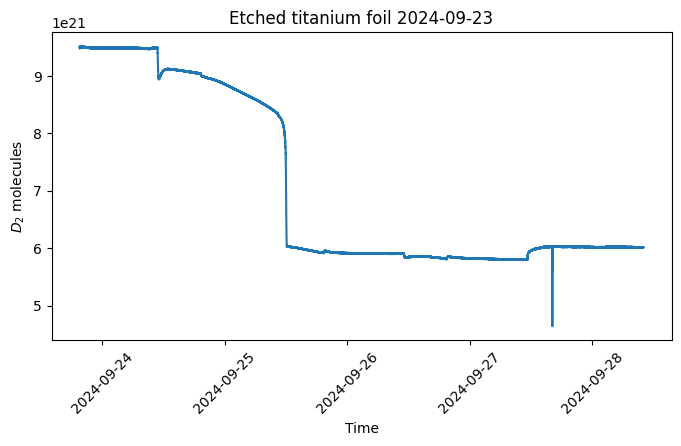

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(combined_df['$D_2$ molecules'])
plt.xlabel('Time')
plt.ylabel('$D_2$ molecules')
plt.xticks(rotation=45)
plt.title(f"{meta['descriptor']} {combined_df.index[0].date()}")
plt.show()

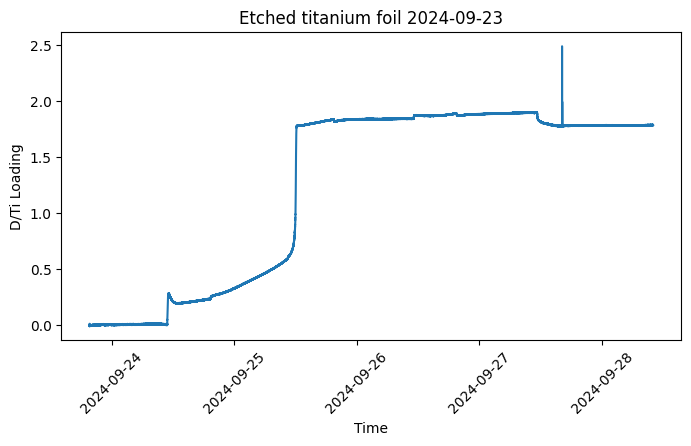

In [22]:
plt.figure(figsize=(8, 4))
plt.plot(combined_df['D/Ti Loading'])
plt.xlabel('Time')
plt.ylabel('D/Ti Loading')
plt.xticks(rotation=45)
plt.title(f"{meta['descriptor']} {combined_df.index[0].date()}")
plt.show()

## Visualising the data

Let's look at the whole data range first

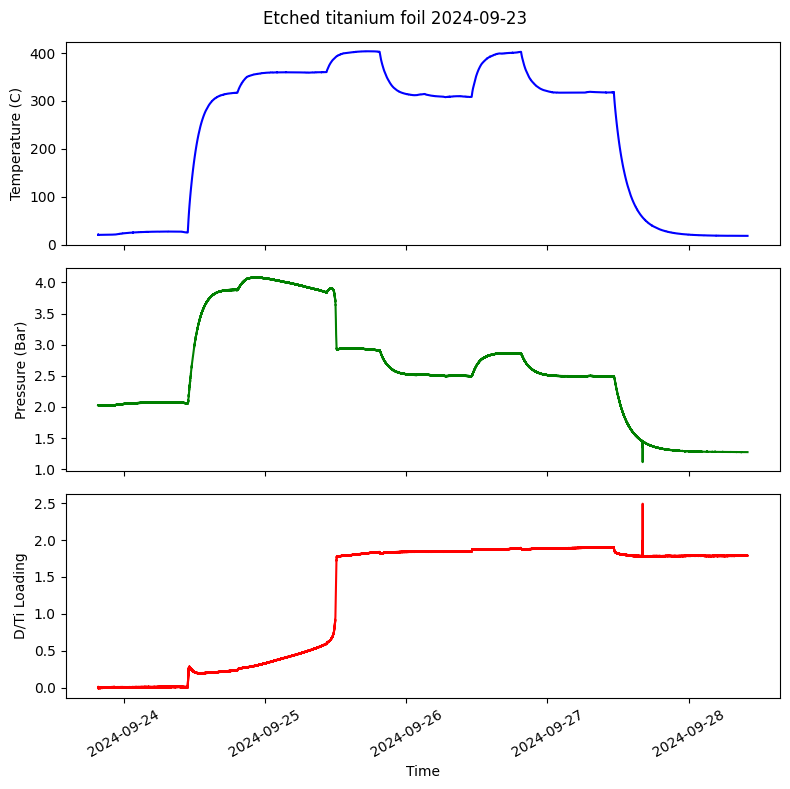

In [23]:
fig, axes = plot_panels(combined_df, ['Temperature (C)', 'Pressure (Bar)', 'D/Ti Loading'],
                        colors=['blue', 'green', 'red'])

Let's also take a look at a pressure/temperature phase space plot, for ideal gas behaviour, we'd expect

$$10^{5}P(atm) = \frac{N_{D_2}k_BT(C)}{V} + \frac{273.15N_{D_2}k_B}{V}$$

Because the number of gas molecules $N_{D_2}$ appears in both the gradient term and offset term, the motion around phase space can look quite complicated. Let's see.

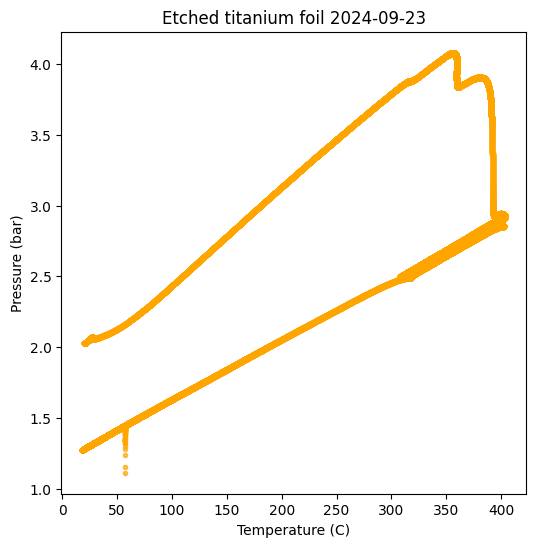

In [24]:
# Create a scatter plot of pressure vs. temperature
plt.figure(figsize=(6, 6))
plt.scatter(combined_df['Temperature (C)'], combined_df['Pressure (Bar)'], marker=".", color='orange', alpha=0.7)

# Label axes
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (bar)')

# Add title
plt.title(f"{meta['descriptor']} {combined_df.index[0].date()}")

# Display the plot
plt.show()

If we down-sample the data a bit, we can get a bit more sense of the dynamics from the scatter plot. It also allows us to see potentially interesting points that we'd like to pay more attention to. For example:

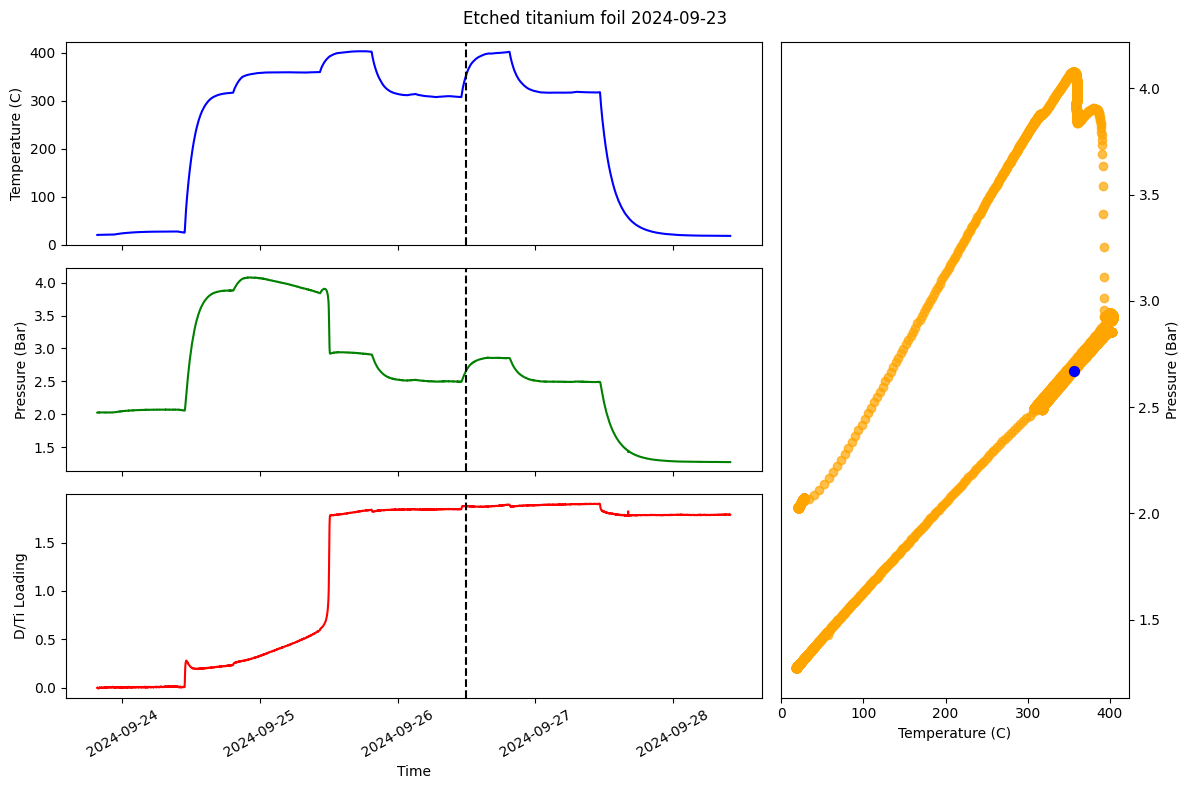

In [25]:
fig, panel_axes, scatter_axes = plot_panels_with_scatter(combined_df, ['Temperature (C)', 'Pressure (Bar)', 'D/Ti Loading'],
                   "Temperature (C)", "Pressure (Bar)",
                        colors=['blue', 'green', 'red'], downsample=100, marker="2024-09-26 12:00")

And by far the best way to get a feeling for the dynamics is to animate everything.

In [26]:
fig, panel_axes, scatter_axes = plot_panels_with_scatter(combined_df, ['Temperature (C)', 'Pressure (Bar)', 'D/Ti Loading'],
                  "Temperature (C)", "Pressure (Bar)",
                        colors=['blue', 'green', 'red'], downsample=100, animate=True)

Animation saved at 'media/Etched titanium foil 2024-09-23.mp4'


In [27]:
# If working in colab, then set embed=True
Video("media/Etched titanium foil 2024-09-23.mp4", embed=False, width=800)

Let's now revisit the P-T phase diagram and this time overlay what we would expect from the ideal gas law.

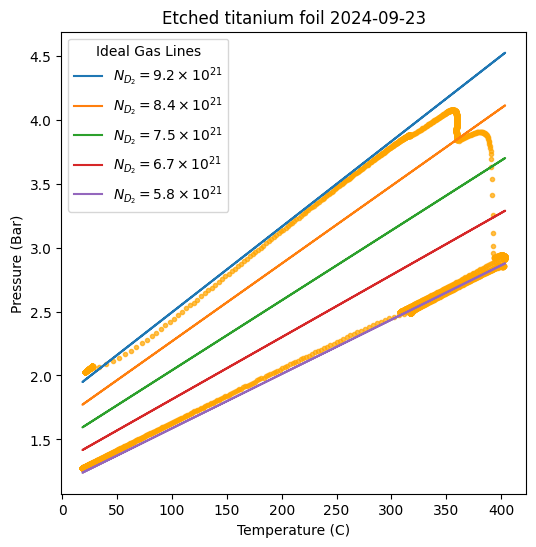

In [28]:
downsample = 100

# Downsample the data
combined_df_downsampled = combined_df.iloc[::downsample]

# Create a scatter plot of pressure vs. temperature
plt.figure(figsize=(6, 6))
plt.scatter(combined_df_downsampled['Temperature (C)'], combined_df_downsampled['Pressure (Bar)'], marker=".", color='orange', alpha=0.7)

# Label axes
plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (Bar)')

# Add title
plt.title(f"{meta['descriptor']} {combined_df_downsampled.index[0].date()}")

combined_df['$D_2$ molecules'].min()

# Generate ideal gas lines for different N_D2 values
N_D2_values = np.linspace(9.2e21, 5.85e21, 5)

# # Add custom values, e.g., 100 and 200
# custom_values = [100, 200]
# N_D2_values = np.append(N_D2_values, custom_values)
# N_D2_values = np.unique(N_D2_values)  # Optional: Remove duplicates and sort

temperatures_C = combined_df_downsampled['Temperature (C)']
temperatures_K = temperatures_C + 273.15  # Convert Celsius to Kelvin

for N_D2 in N_D2_values:
    # Calculate pressure in Pa and convert to Bar (1 Pa = 1e-5 Bar)
    pressures_Pa = (N_D2 * kB * temperatures_K) / V
    pressures_Bar = pressures_Pa * 1e-5

    # Extract the mantissa and exponent separately
    mantissa = f"{N_D2:.1e}".split("e")[0]  # Get the coefficient
    exponent = f"{N_D2:.1e}".split("e")[1]  # Get the exponent, like +21 or +22
    exponent = exponent.replace('+', '')    # Remove any plus sign from the exponent

    # Create the label with explicit LaTeX formatting
    label = f'$N_{{D_2}} = {mantissa} \\times 10^{{{exponent}}}$'

    # Plot the line for this N_D2 value
    plt.plot(temperatures_C, pressures_Bar, label=label)

# Show legend for clarity
plt.legend(title='Ideal Gas Lines')

# Display the plot
plt.show()